# Landkreis: Weekly Cases + Deaths Model

## ToDo
* add uncertainty to mortality rate
* add reporting factor to death curve too
* multiple age groups
* use Refdata instead of Meldedatum
* try out scaling

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps
import xarray as xr

In [ ]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [ ]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')
df_rki['Meldeverzug'] = (df_rki['Meldedatum'] - df_rki['Refdatum']).dt.days

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

In [ ]:
df_rki[:3]

In [ ]:
df_rki['Altersgruppe'].unique()

In [ ]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']
weeks_ending = weeks_ending.set_index('week')['last_dow']
weeks_ending.name = 'Last Day of Week'

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
max_complete_week = complete.index.max()
first_death_week = df_rki.query('AnzahlTodesfall > 0')['week'].min()
first_death_week, max_complete_week

In [ ]:
weekly_totals = df_rki.query('week >= @first_death_week')\
                     .groupby(['week', 'Altersgruppe'])[['AnzahlFall']].sum()

sns.lineplot(x='week',y='AnzahlFall', hue='Altersgruppe', data=weekly_totals.reset_index())
plt.title('Neue Fälle');

In [ ]:
from matplotlib import ticker

case_weighted = df_rki.groupby('Meldeverzug')['AnzahlFall'].sum()
case_weighted.loc[-5:30].plot()

## Refdatum vs Meldedatum

In [ ]:
by_begin = df_rki.groupby(['Meldedatum', 'IstErkrankungsbeginn'])['AnzahlFall'].sum().reset_index()
by_begin = by_begin.pivot(index='Meldedatum', columns='IstErkrankungsbeginn', values='AnzahlFall').fillna(0)
by_begin.plot()

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

In [ ]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [ ]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

In [ ]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

In [ ]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:22]
cum_tt_death = lognorm_frame(2.865, 0.533)

def to_weekly_dist(dist):
    week_starts = np.array(range(0,len(dist) + 1, 7))
    cum_dist = dist.cumsum() / dist.sum()
    weekly = (cum_dist[week_starts] - cum_dist[week_starts].shift(1).fillna(0))
    weekly.index = (weekly.index / 7).astype(int)
    return weekly

infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
to_weekly_dist(infection_to_death).plot(figsize=(5,2))
plt.title('Infection to Death')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [ ]:
inf_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
for  i in range(3, 8):
    print(f'{inf_to_death.cumsum()[i * 7]:.0%} of deaths during first {i} weeks')

### 90% of deaths happen in the first 6 weeks after infection

In [ ]:
weekly_incubation = to_weekly_dist(cum_inc_time)
weekly_incubation[1:].plot(figsize=(5,2))
plt.title('Incubation Period')
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.xlabel('week');

In [ ]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

In [ ]:
kreise = df_rki.groupby('Landkreis')['AnzahlTodesfall'].sum().sort_values(ascending=False)
kreise[kreise.index.str.startswith('SK B')]
kreise['LK Pinneberg'], kreise['SK Berlin Friedrichshain-Kreuzberg']

In [ ]:
cases_by_age = df_rki.query("week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")\
                     .groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum()\
                     .reset_index()
to_drop = cases_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
cases_by_age = cases_by_age[~to_drop]
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=cases_by_age)

In [ ]:
complete_weeks = df_rki.query("week >= @first_death_week and week <= @max_complete_week and Landkreis == 'SK Berlin Friedrichshain-Kreuzberg'")
deaths_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = deaths_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(deaths_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
deaths_by_age['cartesian_key'] = True

deaths_by_age = deaths_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=deaths_by_age)

## Bayesian cases based on deaths

In [20]:
min_death_week_2 = deaths_by_age.query('AnzahlTodesfall > 0')['week'].min()
# start death data with first week where there are still 0 deaths.
death_start_week = min_death_week_2 - 1

# allow time for cases to lead to deaths at week min_death_week
start_offset = 2
start_week = death_start_week - start_offset
# deaths from last week might not be reported yet
death_end_week = max_complete_week - 5
n_death_weeks = death_end_week - death_start_week + 1
n_weeks = max_complete_week - start_week + 1
print(f'n_weeks: {n_weeks}, start_week: {start_week}')
f'death_start_week: {death_start_week}, death_end_week: {death_end_week}, n_death_weeks: {n_death_weeks}'

n_weeks: 12, start_week: 9


'death_start_week: 11, death_end_week: 15, n_death_weeks: 5'

In [21]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL[:3,:3]

(11, 11)


array([[1., 0., 0.],
       [2., 1., 0.],
       [3., 2., 1.]])

In [22]:
def create_delay_matrix(delay):
    def pad_delay_series(delay):
        if n_weeks > delay.shape[0]:
            padded_delay = np.concatenate([delay.values, 
                                           np.zeros(n_weeks - delay.shape[0])])
        else:
            padded_delay = delay.values[:n_weeks]
        padded_delay = pd.Series(padded_delay)
        return padded_delay
    padded_delay = pad_delay_series(delay)
    res = [padded_delay.shift(i).fillna(0).values for i in range(n_weeks)]
    return np.array(res).T

DD = create_delay_matrix(weekly_incubation)
# n_weeks, n_weeks
print(DD.shape)
DD[:3,:3]

(12, 12)


array([[0.        , 0.        , 0.        ],
       [0.75535453, 0.        , 0.        ],
       [0.21460865, 0.75535453, 0.        ]])

In [23]:
age_groups = mortality['Altersgruppe']
grouped = df_rki.query("week >= @start_week and "
                       "week <= @max_complete_week and "
                       "Altersgruppe in @age_groups") \
                .groupby(['week', 'Landkreis', 'Altersgruppe'])[['AnzahlFall', 'AnzahlTodesfall']] \
                .sum() \
                .unstack('Altersgruppe')
# we are unstacking Altersgruppe first, so that all Lankreise have all Altergruppen 
grouped = grouped.unstack('Landkreis') \
                 .swaplevel(1,2, axis=1) \
                 .fillna(0) \
                 .sort_index(axis=1, level=[0,1,2])
# all Landkreise have the same number of Altersgruppen
assert grouped.stack(level=[1,2]).groupby(['Landkreis', 'week']).size().value_counts().shape[0] == 1
grouped

AnzahlFall                                                    \
Landkreis    LK Ahrweiler                      LK Aichach-Friedberg           
Altersgruppe      A15-A34 A35-A59 A60-A79 A80+              A15-A34 A35-A59   
week                                                                          
9                     0.0     0.0     0.0  0.0                  0.0     0.0   
10                    0.0     0.0     0.0  0.0                  1.0     0.0   
11                    3.0     6.0     1.0  0.0                  0.0     4.0   
12                   11.0    16.0     8.0  0.0                  5.0    18.0   
13                    7.0     8.0     5.0  0.0                 12.0    43.0   
14                    5.0    15.0     5.0  0.0                  9.0    22.0   
15                    4.0     6.0     3.0  1.0                  6.0    19.0   
16                    0.0     1.0     1.0  0.0                  3.0    13.0   
17                    1.0     1.0     1.0  0.0                  3.0     4.0   
18                    2.0     8.0     2.0  1.0                  4.0     0.0   
19                    5.0     8.0     0.0  0.0                  0.0     4.0   
20                    4.0     4.0     1.0  0.0                  1.0     0.0   

                                                       ... AnzahlTodesfall  \
Landkreis                  LK Alb-Donau-Kreis          ...     SK Würzburg   
Altersgruppe A60-A79  A80+            A15-A34 A35-A59  ...         A60-A79   
week                                                   ...                   
9                0.0   0.0                0.0     1.0  ...             0.0   
10               0.0   0.0                1.0     3.0  ...             0.0   
11               1.0   1.0                2.0    10.0  ...             0.0   
12               2.0   0.0                9.0    31.0  ...             0.0   
13              19.0   4.0               40.0    85.0  ...             3.0   
14              15.0  10.0               36.0    65.0  ...             1.0   
15              16.0  13.0               18.0    29.0  ...             0.0   
16               6.0   9.0               12.0    24.0  ...             0.0   
17               4.0   1.0                3.0    21.0  ...             0.0   
18               1.0   0.0                3.0     6.0  ...             0.0   
19               0.0   1.0                3.0    13.0  ...             0.0   
20               0.0   1.0                7.0    16.0  ...             0.0   

                                                                           \
Landkreis          SK Zweibrücken                      StadtRegion Aachen   
Altersgruppe  A80+        A15-A34 A35-A59 A60-A79 A80+            A15-A34   
week                                                                        
9              0.0            0.0     0.0     0.0  0.0                0.0   
10             0.0            0.0     0.0     0.0  0.0                0.0   
11             7.0            0.0     0.0     0.0  0.0                0.0   
12             9.0            0.0     0.0     0.0  0.0                0.0   
13            14.0            0.0     0.0     0.0  0.0                0.0   
14             8.0            0.0     0.0     0.0  0.0                0.0   
15             6.0            0.0     0.0     0.0  0.0                0.0   
16             0.0            0.0     1.0     0.0  0.0                0.0   
17             0.0            0.0     0.0     0.0  0.0                0.0   
18             0.0            0.0     0.0     0.0  0.0                0.0   
19             0.0            0.0     0.0     0.0  0.0                0.0   
20             0.0            0.0     0.0     0.0  0.0                0.0   

                                    
Landkreis                           
Altersgruppe A35-A59 A60-A79  A80+  
week                                
9                0.0     0.0   0.0  
10               0.0     0.0   0.0  
11               1.0     1.0   2.0  
12       

In [513]:
cases = grouped['AnzahlFall'].iloc[:, 0:64]
deaths = grouped['AnzahlTodesfall'].loc[death_start_week:death_end_week].iloc[:, :64]
cases.shape, deaths.shape

((12, 128), (5, 64))

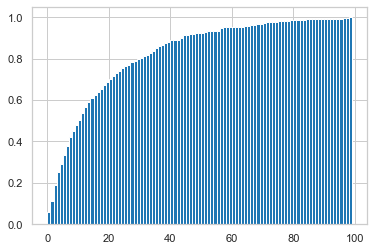

In [514]:
lks = df_rki.query("week >= @start_week and "
                   "week <= @max_complete_week and "
                   "Altersgruppe in @age_groups") \
                .groupby('Landkreis')[['AnzahlFall', 'AnzahlTodesfall']].sum().sort_values('AnzahlTodesfall')
lks['AnzahlTodesfall'].hist(bins=range(0, 100, 1), cumulative=True, density=True)

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

Let $\gamma$ be ther inverse of the generation time. We model the number of $deaths(t)$ for people who got infected at time $t$.
$$ 
\begin{eqnarray}
\text{new infections}(t) &:=& \text{new infections}(t-1) \cdot e^{\gamma (r(t) -1)} \\
\operatorname{log}(\text{new infections})(t) &=& \operatorname{log}(\text{new infections}(t-1)) + \gamma (r(t) -1) \\
\text{expected cases}(t) &:=& \text{DelayMatrix} \cdot \text{new infections}(t) \\
\text{new deaths}(t) &:=& \operatorname{Normal}(\text{expected cases}(t) \cdot \text{mortality}(t))
\end{eqnarray}
$$

For each Landkreis we draw a mean growth rate $r_L$ and each age group gets a growth rate $r_{L,a}$ drawn from a narrow distribution around $r_L$.

In [515]:
n_age_groups = age_groups.shape[0]
n_counties = int(cases.shape[1] / n_age_groups)
n_age_groups, n_counties

(4, 32)

In [516]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 6/7

# shape = weeks, (counties, age_groups)

with pm.Model() as model:
    # r[0] 
    # county priors
    r_l_zero_mu = pm.Normal('r_l_zero_mu', np.log(3), .1)
    r_l_zero_sigma = pm.Gamma('r_l_zero_sigma', mu=0.5, sigma=.1)
    r_l_zero = pm.Normal('r_l_zero', r_l_zero_mu, r_l_zero_sigma, shape=n_counties)
    # age groups in counties
    r_la_zero_sigma = pm.Gamma('r_la_zero_sigma', mu=0.4, sigma=.1)
    r_la_zero = pm.Normal('r_la_zero', r_l_zero, r_la_zero_sigma, shape=(n_age_groups, n_counties)) \
                  .T.reshape([1, n_age_groups * n_counties])
    
    # r[1:]
    # county priors
    r_l_delta_mu = pm.Normal('r_l_delta_mu', 0, .15, shape=n_weeks-2)
    r_l_delta_sigma = pm.Gamma('r_l_delta_sigma', mu=0.7, sigma=.15, shape=n_weeks-2)
    r_l_delta = pm.Normal('r_l_delta', r_l_delta_mu, r_l_delta_sigma, shape=(n_counties, n_weeks-2))
    # age groups in counties
    r_la_delta_sigma = pm.Gamma('r_la_delta_sigma', mu=0.4, sigma=.1, shape=n_weeks-2)
    r_la_delta = pm.Normal('r_la_delta', r_l_delta, r_la_delta_sigma, shape=(n_age_groups, n_counties, n_weeks-2)) \
                   .T.reshape([n_weeks-2, n_age_groups * n_counties])
    
    # shape (n_weeks-1, n_age_groups * n_counties)
    r_la = pm.Deterministic('r_la', pm.math.concatenate([r_la_zero, r_la_delta], axis=0))
    
    # start values for weekly new infections
    # county priors
    start_inf_l_mu = pm.Normal('start_inf_l_mu', mu=1, sigma=5)
    start_inf_l_sigma = pm.Gamma('start_inf_l_sigma', mu=0.6, sigma=.2)
    start_inf_l = pm.Normal('start_inf_l', start_inf_l_sigma, shape=n_counties)
    # age groups in counties
    start_inf_l_a_simga = pm.Gamma('start_inf_l_a_simga', mu=0.4, sigma=.1)
    start_inf_l_a = pm.Normal('start_inf_l_a', start_inf_l, start_inf_l_a_simga, shape=(n_age_groups, n_counties)) \
                      .T.reshape([1, n_age_groups * n_counties])
    
    
    # TODO: make the growth a logit
    # use matrix TRIL to vectorize the stepwise linear growth of the log_infections
    log_infection_following = start_inf_l_a + pm.math.dot(TRIL, r_la / serial_interval)
    log_infections = pm.Deterministic('log_infections', 
        pm.math.concatenate([start_inf_l_a, log_infection_following], axis=0))
    print(f'shape of log_infection {log_infections.tag.test_value.shape}')
    
    # expected cases
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_cases = pm.Deterministic('expected_cases', pm.math.dot(DD, np.exp(log_infections)))
    print(f'shape of expected_cases {expected_cases.tag.test_value.shape}')
    
    # case reporting rate
    case_reporting_rate_zero = pm.Gamma('case_reporting_rate_zero', mu=0.3, sigma=.1)
    reporting_sigma = 3 / (5 + np.arange(1, n_weeks-1))
    case_reporting_rate_factors = pm.Gamma('case_reporting_rate_factors', mu=1, sigma=reporting_sigma, shape=n_weeks-2)
    print(case_reporting_rate_factors.dshape)
    log_case_rep_rate = np.log(pm.math.concatenate([case_reporting_rate_zero.flatten(),
                                                    case_reporting_rate_factors]))                              
    case_reporting_rates = pm.Deterministic('case_reporting_rates', 
                                            np.exp(pm.math.dot(np.tril(np.ones(n_weeks-1)), 
                                                               log_case_rep_rate))) \
                             .reshape([-1, 1])
    
    
    # the week of the first infections we still don't have cases, because of the incubation period
    reported_cases = pm.Normal('reported_cases', 
                                expected_cases[1:] * case_reporting_rates, 
                                # the plus 50 allows for undetected cases in the beginning
                                np.sqrt(expected_cases[1:] * case_reporting_rates) * 10 + .1, 
                                shape=(n_weeks-1, n_age_groups * n_counties),
                                observed=cases[1:])
    
    repeated_mortalities = np.repeat(mortality.sort_values('Altersgruppe')['mortality'], n_counties)
    expected_deaths = pm.Deterministic('expected_deaths', expected_cases * repeated_mortalities)
    obs_deaths = pm.Normal('obs_deaths', 
                            expected_deaths[start_offset:start_offset+n_death_weeks],
                            sigma=np.sqrt(expected_deaths[start_offset:start_offset+n_death_weeks]),
                            shape=n_weeks, 
                            observed=deaths)
    
#print(model.test_point)
model.check_test_point()

shape of log_infection (12, 128)
shape of expected_cases (12, 128)
(10,)


ValueError: Input dimension mis-match. (input[0].shape[1] = 64, input[1].shape[1] = 128)

In [ ]:
def week_numbers_to_dates(week_numbers):
    return weeks_ending.loc[week_numbers]


def plot_sample_with_quantiles(sample_values, alpha=0.1, label=None, ax=None, color='C0'):
    if ax is None:
        plt.figure(figsize=(14, 3))
        ax = plt.gca()
    plot_with_q = sample_values.apply(pd.Series.quantile, q=[alpha/2, 0.25, 0.5, 0.75, 1 - alpha/2]).T

    if label is None:
        label = 'model'
    plot_with_q[0.5].plot(ax=ax, label=label+' median', color=color)
    ax.fill_between(plot_with_q.index,
                     plot_with_q[0.25],
                     plot_with_q[0.75], 
                     alpha=0.2,
                     label=f'50% prediction interval',
                     color=color)
    ax.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label=f'{100 * (1 - alpha)}% prediction interval',
                     color=color)

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=1000, model=model, vars=[obs_var_name])[obs_var_name]
    reported_cases = xr.DataArray(y, 
                              dims=('draw', 'week', 'l_a'), 
                              coords={
                                  'draw': range(1000),
                                  'week': cases.index[1:],
                                  'l_a': cases.columns
                              })
    # draw, week, Landkreis
    county_cases = reported_cases.unstack().mean(dim='Altersgruppe')
    # observed cases
    grouped_cases = cases.groupby(level=0, axis=1).sum()
    
    for county in county_cases.indexes['Landkreis'][:2]:
        one_county_cases = county_cases.sel({'Landkreis': county}) \
                                       .to_dataframe('expected_cases')['expected_cases'].unstack()
        plot_sample_with_quantiles(one_county_cases)
        grouped_cases[county].plot(label='true value', marker='o', color='C1')
        plt.title(county)
        plt.ylim([0, 2e2])
        plt.legend(loc='upper left')
    return y
    

# And run the sanity check
y = sanity_check(cases, 'reported_cases')

In [518]:
with model:
    #print(model.test_point)
    trace = pm.sample(init='adapt_diag')
    #trace = pm.sample(10000, tune=5000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [case_reporting_rate_factors, case_reporting_rate_zero, start_inf_l_a, start_inf_l_a_simga, start_inf_l, start_inf_l_sigma, start_inf_l_mu, r_la_delta, r_la_delta_sigma, r_l_delta, r_l_delta_sigma, r_l_delta_mu, r_la_zero, r_la_zero_sigma, r_l_zero, r_l_zero_sigma, r_l_zero_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 28000/28000 [19:17<00:00, 24.19draws/s]
The number of effective samples is smaller than 10% for some parameters.


## Plot Model against Data

### Add labels to model output

In [519]:
r_l = np.concatenate([trace['r_l_zero'][:,:, None], trace['r_l_delta']], axis=2)
r_l = xr.DataArray(r_l,
                  dims=('draw', 'Landkreis', 'week'),
                  coords={
                      'week': cases[:-1].index,
                      'Landkreis': cases.columns.get_level_values(0).drop_duplicates()
                  })

infections = xr.DataArray(np.exp(trace['log_infections']),
                          dims=('draw', 'week', 'l_a'), 
                          coords={
                              'week': cases.index,
                              'l_a': cases.columns
                          }).unstack()

model_cases = xr.DataArray(trace['expected_cases'][:,1:, :], 
                              dims=('draw', 'week', 'l_a'), 
                              coords={
                                  'week': cases.index[1:],
                                  'l_a': cases.columns
                              }).unstack()

model_reported_cases = trace['expected_cases'][:,1:, :] * trace['case_reporting_rates'][:,:,None]
model_reported_cases = xr.DataArray(model_reported_cases, 
                                    dims=('draw', 'week', 'l_a'), 
                                    coords={
                                        'week': cases.index[1:],
                                        'l_a': cases.columns
                                    }).unstack()

model_deaths = xr.DataArray(trace['expected_deaths'][:,:, :], 
                            dims=('draw', 'week', 'l_a'), 
                            coords={
                                'week': cases.index,
                                'l_a': cases.columns
                            }).unstack()

county_model_cases = model_cases.sum(dim='Altersgruppe')
county_model_reported_cases = model_reported_cases.sum(dim='Altersgruppe')
county_cases = cases.groupby(level=0, axis=1).sum()
county_deaths = deaths.groupby(level=0, axis=1).sum()

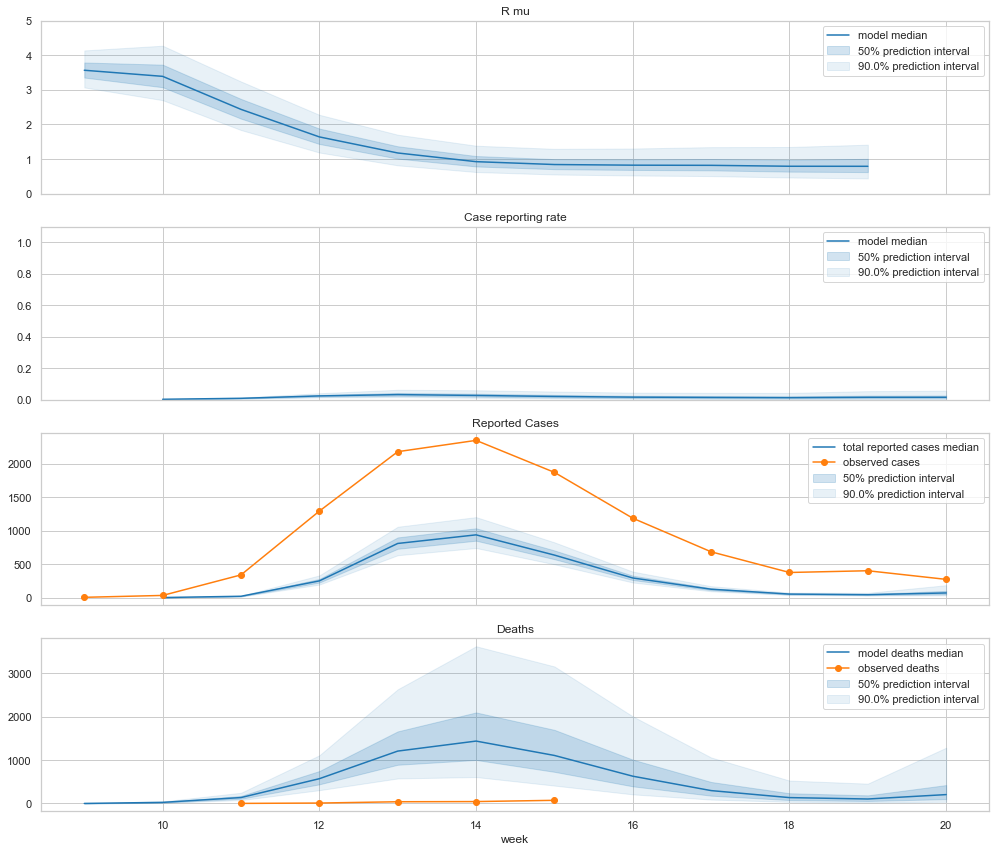

In [520]:
fig, axes = plt.subplots(4, 1,
                         figsize=(14, 12), sharex=True)
r = np.concatenate([trace['r_l_zero_mu'].reshape(-1,1), trace['r_l_delta_mu']], axis=1)
r_eff = pd.DataFrame(np.exp(np.cumsum(r, axis=1)), columns=cases[:-1].index)
plot_sample_with_quantiles(r_eff, ax=axes[0])
axes[0].set_title('R mu')
axes[0].set_ylim([0, 5])
axes[0].legend()

rep_rates = pd.DataFrame(trace['case_reporting_rates'], columns=cases[1:].index)
plot_sample_with_quantiles(rep_rates, ax=axes[1])
axes[1].legend(loc='upper right')
axes[1].set_ylim([0, 1.1])
axes[1].set_title('Case reporting rate')


total_reported_cases = model_reported_cases.sum(dim=['Altersgruppe', 'Landkreis']) \
                                           .to_dataframe('expected_cases')['expected_cases'] \
                                           .unstack()
plot_sample_with_quantiles(total_reported_cases, label='total reported cases', ax=axes[2])
cases.stack(level=[0,1]) \
     .groupby('week') \
     .sum() \
     .plot(label='observed cases', ax=axes[2], marker='o', color='C1')
axes[2].set_title('Reported Cases')
axes[2].legend(loc='upper right')

total_model_deaths = model_deaths.sum(dim=['Altersgruppe', 'Landkreis']) \
                           .to_dataframe('expected_cases')['expected_cases'] \
                           .unstack()
plot_sample_with_quantiles(total_model_deaths, label='model deaths', ax=axes[3])
deaths.stack(level=[0,1]) \
      .groupby('week') \
      .sum() \
      .plot(label='observed deaths', ax=axes[3], marker='o', color='C1')
axes[3].set_title('Deaths')
axes[3].legend(loc='upper right')

# axes[2].legend(loc='upper right')
# #axes[2].set_ylim([0, 1e2])
# axes[2].set_title('Expected vs Reported Cases')

# plot_sample_with_quantiles(trace['expected_deaths'], start_week, ax=axes[3])
# to_plot = deaths.loc[min_death_week:death_end_week].copy()
# to_plot.index = week_numbers_to_dates(to_plot.index)
# to_plot.plot(label='observed deaths', marker='o', ax=axes[3])
# axes[3].legend()
# axes[3].set_title('Deaths by Case Reporting Date');

# for i in range(3):
#     axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
plt.tight_layout()

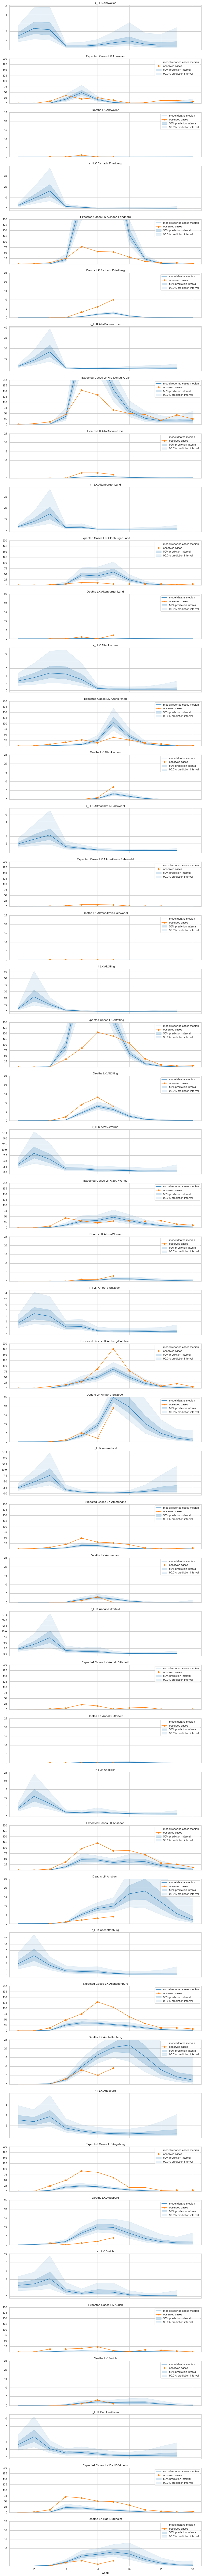

In [511]:
fig, axes = plt.subplots(3 * n_counties, 1,
                         figsize=(14, n_counties * 12), sharex=True)
i = 0
for county in model_reported_cases.indexes['Landkreis']: 
    county_r = r_l.sel({'Landkreis': county}) \
                  .to_dataframe('r_l')['r_l'] \
                  .unstack()
    county_r_eff = np.exp(county_r.cumsum(axis=1))
    plot_sample_with_quantiles(county_r_eff, label='county r', ax=axes[i])
    axes[i].set_title(f'r_l {county}')
    i += 1
    
#     county_inf = infections.sel({'Landkreis': county}) \
#                            .sum(dim='Altersgruppe') \
#                            .to_dataframe('infections')['infections'] \
#                            .unstack()
#     plot_sample_with_quantiles(county_inf, label='infections', ax=axes[i])
#     axes[i].set_title(f'Infections {county}')
#     axes[i].set_ylim([0, 200])
#     i += 1
    
    one_group_model_reported_cases = county_model_reported_cases.sel({'Landkreis': county}) \
                                                                .to_dataframe('expected_cases')['expected_cases'] \
                                                                .unstack()
    plot_sample_with_quantiles(one_group_model_reported_cases, label='model reported cases', ax=axes[i])
    county_cases[county].plot(label='observed cases', ax=axes[i], marker='o', color='C1')
    
#     one_group_model_cases = county_model_cases.sel({'Landkreis': county}) \
#                                               .to_dataframe('expected_cases')['expected_cases'] \
#                                               .unstack()
#     plot_sample_with_quantiles(one_group_model_cases, label='model cases', ax=axes[i], color='C2')
    axes[i].set_title(f'Expected Cases {county}')
    axes[i].set_ylim([0, 200])
    axes[i].legend()
    i += 1
    
    one_group_model_deaths = model_deaths.sum('Altersgruppe') \
                                         .sel({'Landkreis': county}) \
                                         .to_dataframe('expected_cases')['expected_cases'] \
                                         .unstack()
    plot_sample_with_quantiles(one_group_model_deaths, label='model deaths', ax=axes[i])
    county_deaths[county].plot(label='observed cases', ax=axes[i], marker='o', color='C1')
    

    axes[i].set_title(f'Deaths {county}')
    axes[i].set_ylim([0, 25])
    axes[i].legend()
    i += 1

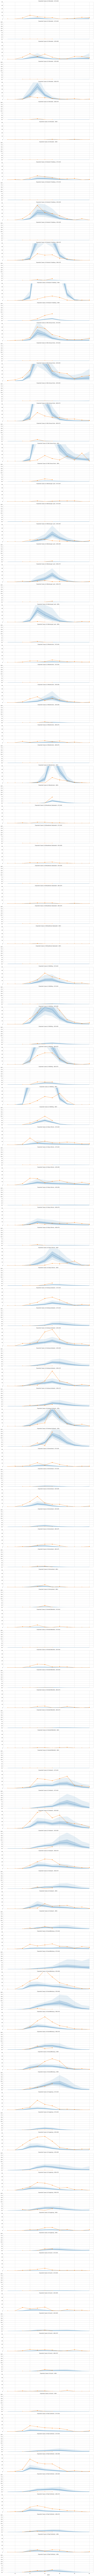

In [512]:
fig, axes = plt.subplots(2 * n_counties * n_age_groups, 1,
                         figsize=(14, n_counties * n_age_groups * 6), sharex=True)
i = 0
for county in model_reported_cases.indexes['Landkreis']:
    for age_group in model_reported_cases.indexes['Altersgruppe']:
        one_group_cases = model_reported_cases.sel({'Landkreis': county, 'Altersgruppe': age_group}) \
                                              .to_dataframe('expected_cases')['expected_cases'].unstack()
        plot_sample_with_quantiles(one_group_cases, label='model reported cases', ax=axes[i])
        cases[county, age_group].plot(label='observed cases', ax=axes[i], marker='o', color='C1')
        axes[i].set_title(f'Expected Cases {county} - {age_group}')
        axes[i].set_ylim([0, 50])
        i += 1
        
        one_group_deaths = model_deaths.sel({'Landkreis': county, 'Altersgruppe': age_group}) \
                                              .to_dataframe('deaths')['deaths'].unstack()
        plot_sample_with_quantiles(one_group_deaths, label='model deaths', ax=axes[i])
        deaths[county, age_group].plot(label='observed deaths', ax=axes[i], marker='o', color='C1')
        axes[i].set_title(f'Deaths {county} - {age_group}')
        axes[i].set_ylim([0, 20])
        i += 1
plt.tight_layout()

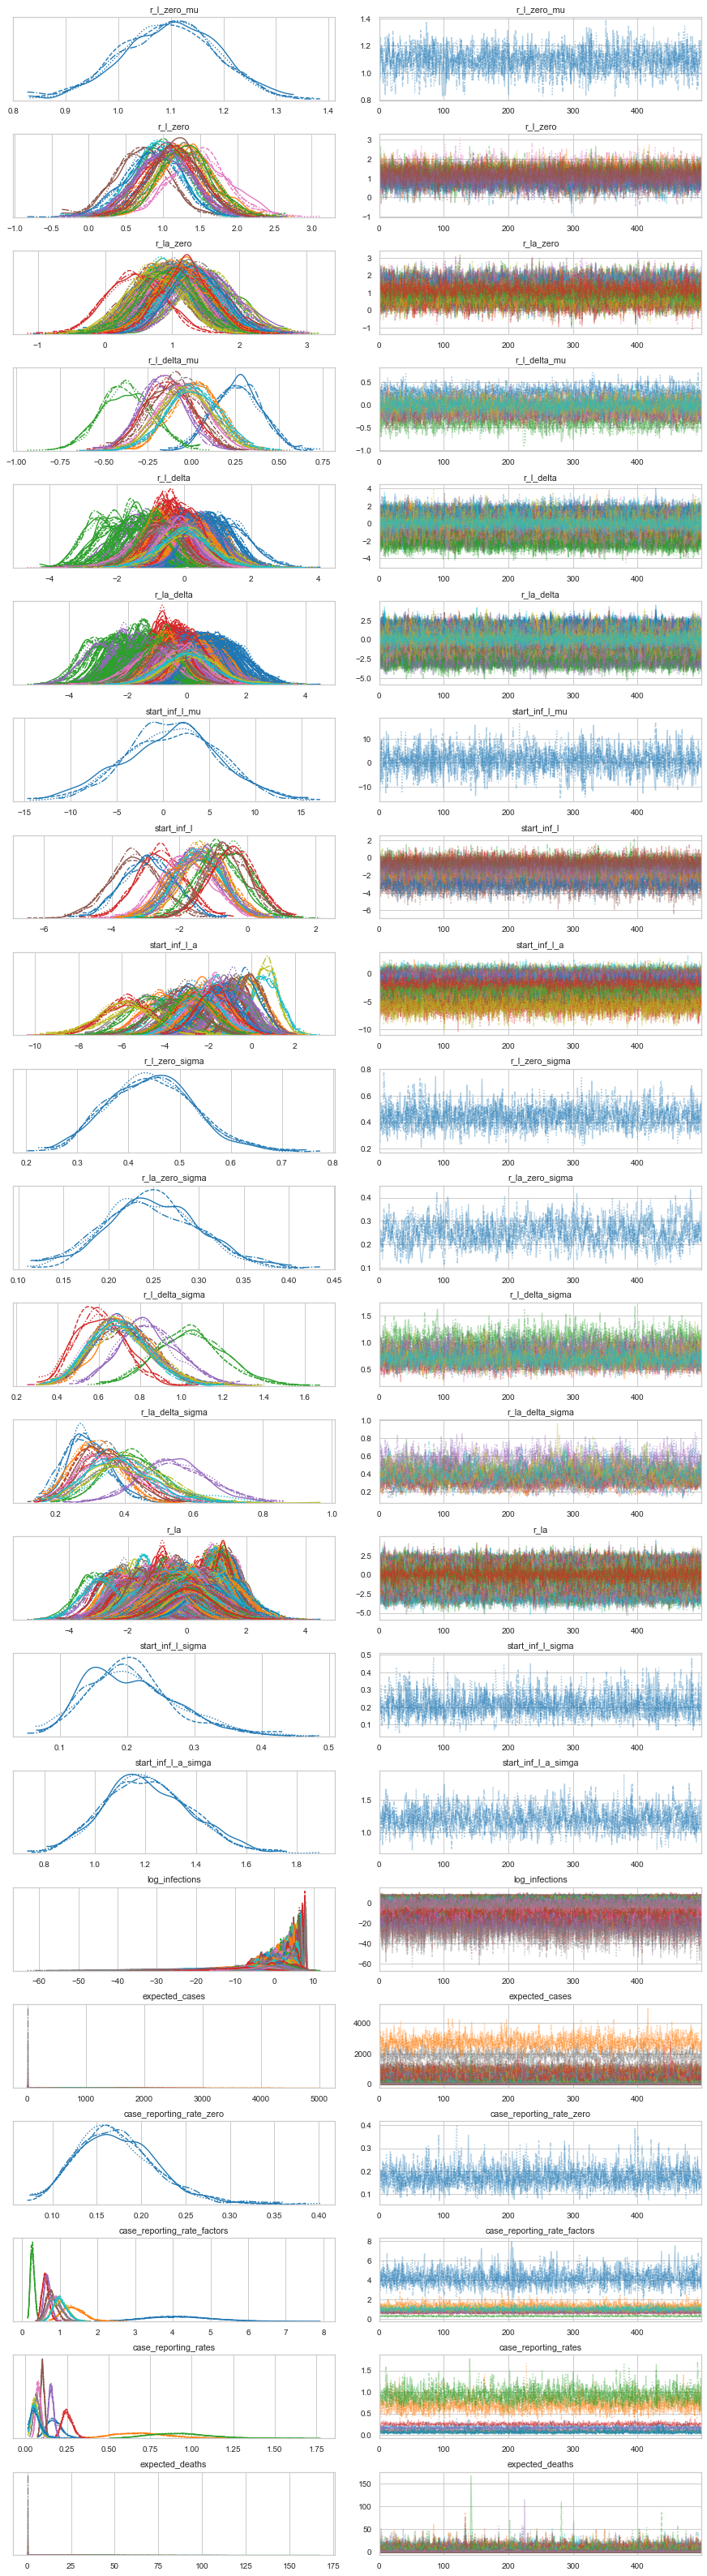

In [453]:
_ = pm.traceplot(trace)

In [325]:
posterior = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 2000/2000 [00:04<00:00, 460.24it/s]


## Distribution Playground

0.1534473404183467 1.7667693904721482


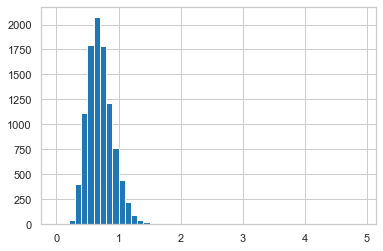

In [291]:
with pm.Model():
    a = pm.Gamma('a', mu=0.7, sigma=.2).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 5, 0.1))
    print(a.min(), a.max())

In [ ]:
with pm.Model():
    a = pm.Gamma('a', mu=, sigma=3).random(size=10000)
    np.exp(pd.Series(a)).hist(bins=np.arange(0, 10, 0.2))
    print(a.min(), a.max())

In [ ]:
pm.Gamma('start_infections', mu=5, sigma=2)

## Theano Playground

In [ ]:
import theano
x = theano.tensor.fvector('x')
x.tag.test_value = np.random.rand(2).astype(np.float32)
W = theano.shared(np.asarray([0.2, 0.7]), 'W')
y = (x * W).sum()
 
f = theano.function([x], y)
output = f([1.0, 1.0])
print(output)

In [ ]:
x